In [1]:
# !pip install matplotlib
# !pip install pandas

In [2]:
import os
import json

ablations_dir = input("Enter the path to the ablations directory: ")

# a line separated list of ids of the contaminated examples (can be generated from bff outputs by grepping for -Ev '"bff_duplicate_spans":\[\]')
contaminated_ids = [line.strip() for line in open(os.path.join(ablations_dir, "ppl_v2_small_val_contam_ids.txt"))]
assert len(contaminated_ids) == len(set(contaminated_ids))
contaminated_ids = set(contaminated_ids)

# the catwalk "prediction.jsonl" outputs
predictions_baseline = [json.loads(line) for line in open(os.path.join(ablations_dir, "predictions/rp_v1_small.jsonl"))]
predictions_decon = [json.loads(line) for line in open(os.path.join(ablations_dir, "predictions/abl-paragraph-decon.jsonl"))]
predictions = {"not decontaminated": predictions_baseline, "decontaminated": predictions_decon}

In [3]:
def update_names(name):

    domain_name_map = {
        "ppl_twitterAEE_small": "ppl_twitterAAE_small",
    }
    if name in domain_name_map:
        return domain_name_map[name]
    return name

for run_name, run in predictions.items():
    for domain in run:
         domain['task'] = update_names(domain['task'])

(0.0, 50.0)

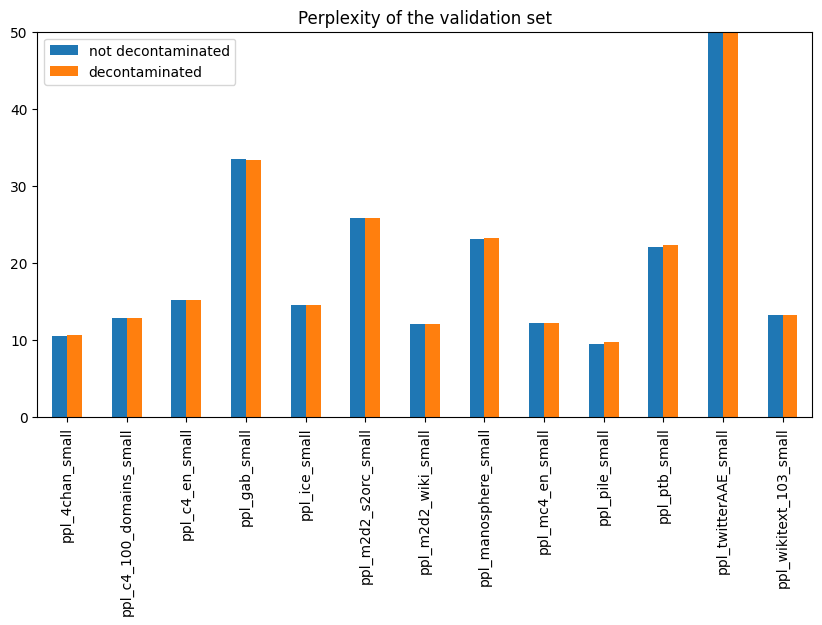

In [4]:
import pandas as pd

all_eval = {
    run_name:{domain['task']:domain['metrics']['ppl_metrics']['ppl_token'] for domain in run}
    for run_name, run in predictions.items() 
}

df_eval = pd.DataFrame(all_eval).T

df_eval.T.plot.bar(figsize=(10, 5), title="Perplexity of the validation set")

# clip the y-axis to make the differences more visible
import matplotlib.pyplot as plt
plt.ylim(0, 50)



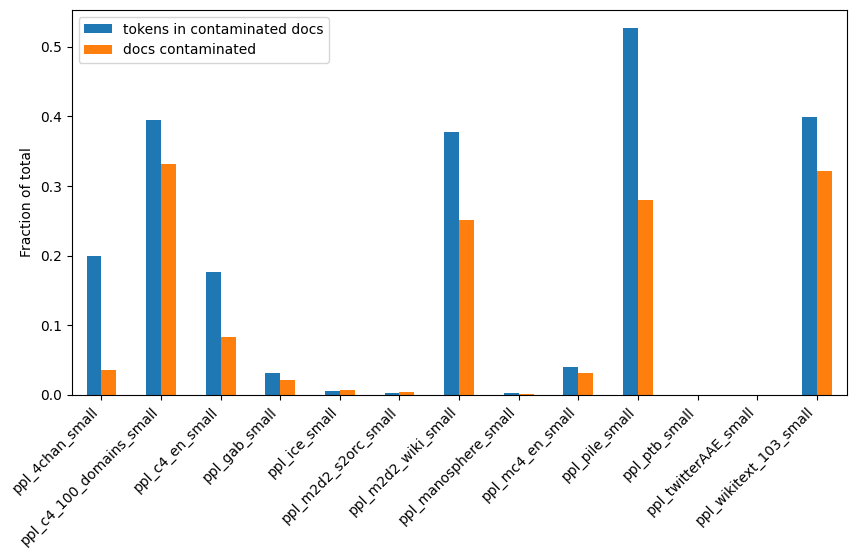

In [17]:
def tokens_contamianted(per_instance, contaminated_ids):
    num_tokens = 0
    total_tokens = 0
    for instance in per_instance:
        total_tokens += instance['prediction']['model_output']['num_tokens']
        if instance['instance']['id'] not in contaminated_ids:
            continue
        num_tokens += instance['prediction']['model_output']['num_tokens']
    return num_tokens / total_tokens

def docs_contamianted(per_instance, contaminated_ids):
    num_docs = 0
    total_docs = 0
    for instance in per_instance:
        total_docs += 1
        if instance['instance']['id'] not in contaminated_ids:
            continue
        num_docs += 1
    return num_docs / total_docs


# recompute ppl_token for just the contaminated ids
tokens_contam = {
    run_name + ' tokens contaminated':{
        domain['task']:tokens_contamianted(domain['per_instance'], contaminated_ids)
        for domain in run
    }
    for run_name, run in predictions.items()
}

assert all(domain1 == domain2 for domain1, domain2 in zip(tokens_contam['not decontaminated tokens contaminated'].values(), tokens_contam['decontaminated tokens contaminated'].values()))

# recompute ppl_token for just the contaminated ids
docs_contam = {
    run_name + ' docs contaminated':{
        domain['task'] :docs_contamianted(domain['per_instance'], contaminated_ids)
        for domain in run
    }
    for run_name, run in predictions.items()
}

assert all(domain1 == domain2 for domain1, domain2 in zip(docs_contam['not decontaminated docs contaminated'].values(), docs_contam['decontaminated docs contaminated'].values()))


# merge first row from each dict
docs_and_tokens_contam = {'tokens in contaminated docs':{**tokens_contam['not decontaminated tokens contaminated']}, 'docs contaminated':{**docs_contam['not decontaminated docs contaminated']}}
df_docs_and_tokens_contam = pd.DataFrame(docs_and_tokens_contam).T

fig = df_docs_and_tokens_contam.T.plot.bar(figsize=(10, 5), ylabel="Fraction of total")
# rotate x-axis labels 45 
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

# output as pdf
fig.get_figure().savefig(os.path.join(ablations_dir, 'figures', "eval_contam_wrt_RP.pdf"), bbox_inches='tight')


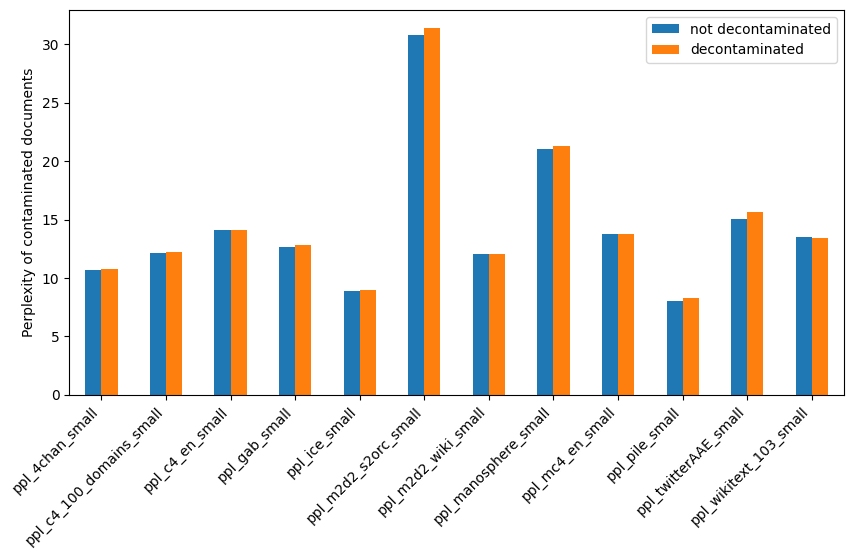

In [12]:
import math

def safe_exp(x):
    try:
        ans = math.exp(x)
    except OverflowError:
        ans = 1e30
    return ans

def recompute_ppl_token(per_instance, contaminated_ids):
    sum_logits = 0
    num_tokens = 0
    for instance in per_instance:
        if instance['instance']['id'] not in contaminated_ids:
            continue
        sum_logits += instance['prediction']['model_output']['sum_logits']
        num_tokens += instance['prediction']['model_output']['num_tokens']
    if num_tokens == 0:
        return None
    return safe_exp(-sum_logits / num_tokens)


# recompute ppl_token for just the contaminated ids
contam_eval = {
    run_name:{
        domain['task']:recompute_ppl_token(domain['per_instance'], contaminated_ids)
        for domain in run if recompute_ppl_token(domain['per_instance'], contaminated_ids) is not None
    }
    for run_name, run in predictions.items()
}

df_contam_eval = pd.DataFrame(contam_eval)


# rename rp-v1-small -> not decontamintated; abl-paragraph-decon -> decontamintated
# df_contam_eval = df_contam_eval.T.rename(columns={'rp-v1-small': 'not decontaminated', 'abl-paragraph-decon': 'decontaminated'})



fig = df_contam_eval.plot.bar(figsize=(10, 5))
fig.set(ylabel="Perplexity of contaminated documents")
# rotate the x-axis labels 45 degrees
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')

# output as pdf
fig.get_figure().savefig(os.path.join(ablations_dir, 'figures', "decon_abl_ppl_just_contaminated.pdf"), bbox_inches='tight')


In [7]:
df_contam_eval

,ppl_4chan_small,ppl_c4_100_domains_small,ppl_c4_en_small,ppl_gab_small,ppl_ice_small,ppl_m2d2_s2orc_small,ppl_m2d2_wiki_small,ppl_manosphere_small,ppl_mc4_en_small,ppl_pile_small,ppl_twitterAAE_small,ppl_wikitext_103_small
not decontaminated,10.667287,12.161260,14.121728,12.692620,8.864227,30.817414,12.036440,21.044311,13.76384,8.061021,15.042319,13.483074
decontaminated,10.764491,12.217218,14.128248,12.836903,8.994149,31.377516,12.095625,21.274032,13.77848,8.310483,15.628254,13.469279


In [8]:
print(f"avg ppl decontaminated: {df_contam_eval.loc['decontaminated'].mean()}")
print(f"avg ppl not decontaminated: {df_contam_eval.loc['not decontaminated'].mean()}")

avg ppl decontaminated: 14.572889652623067
avg ppl not decontaminated: 14.396295050308657


In [9]:
# max diff between contaminated and uncontaminated
diff = df_contam_eval.loc['decontaminated'] - df_contam_eval.loc['not decontaminated']
print(diff.max())
# argmax
print(diff.idxmax())
# sign of the difference
diff > 0

0.585935411656072
ppl_twitterAAE_small


ppl_4chan_small              True
ppl_c4_100_domains_small     True
ppl_c4_en_small              True
ppl_gab_small                True
ppl_ice_small                True
ppl_m2d2_s2orc_small         True
ppl_m2d2_wiki_small          True
ppl_manosphere_small         True
ppl_mc4_en_small             True
ppl_pile_small               True
ppl_twitterAAE_small         True
ppl_wikitext_103_small      False
dtype: bool

In [10]:
df_all = pd.concat([df_contam_eval, df_docs_and_tokens_contam])
df_all = df_all.round(2)
df_all

,ppl_4chan_small,ppl_c4_100_domains_small,ppl_c4_en_small,ppl_gab_small,ppl_ice_small,ppl_m2d2_s2orc_small,ppl_m2d2_wiki_small,ppl_manosphere_small,ppl_mc4_en_small,ppl_pile_small,ppl_twitterAAE_small,ppl_wikitext_103_small,ppl_ptb_small
not decontaminated,10.67,12.16,14.12,12.69,8.86,30.82,12.04,21.04,13.76,8.06,15.04,13.48,NaN
decontaminated,10.76,12.22,14.13,12.84,8.99,31.38,12.10,21.27,13.78,8.31,15.63,13.47,NaN
tokens contaminated,0.20,0.39,0.18,0.03,0.01,0.00,0.38,0.00,0.04,0.53,0.00,0.40,0.0
docs contaminated,0.04,0.33,0.08,0.02,0.01,0.00,0.25,0.00,0.03,0.28,0.00,0.32,0.0


(0.0, 50.0)

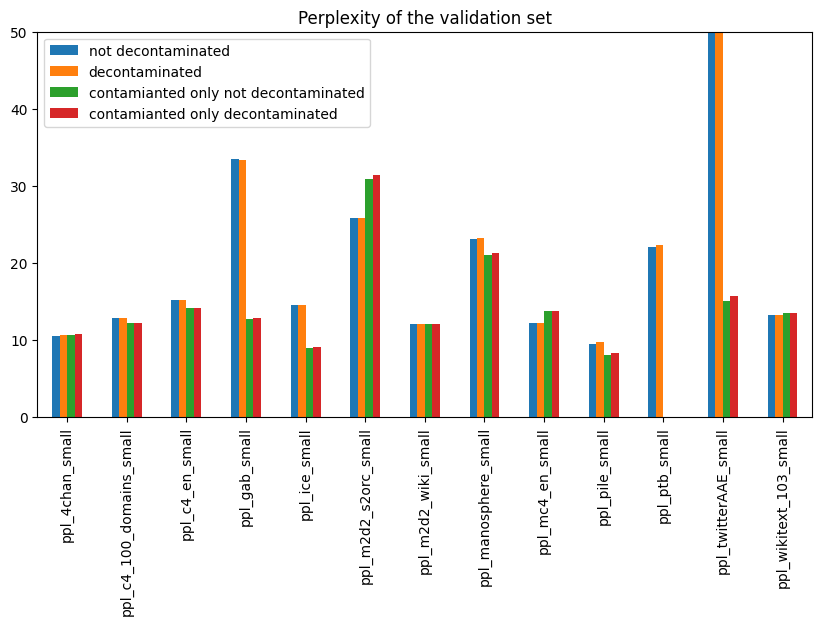

In [11]:
df_contam_eval.index = "contamianted only " + df_contam_eval.index
df_contrast = pd.concat([df_eval, df_contam_eval])
# chart
df_contrast.T.plot.bar(figsize=(10, 5), title="Perplexity of the validation set")

# clip the y-axis to make the differences more visible
import matplotlib.pyplot as plt
plt.ylim(0, 50)